# Paper plots: Predictions 1D

This notebook contains the code necessary to generate many of the plots in the predictions section of the paper.
Here we focus in particular on predictions only as a function of the effective tide $\lambda / \lambda_s$ without any reference to orbiting subhalo scenarios

## Contents of this Notebook:

* Truncation in the density profile
* Velocity profiles and Tidal Track

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

import sys

import numpy as np
sys.path.append("../..")
import adiabatic_tides as at
from scipy.optimize import curve_fit

h5cache = "../../caches/behaviour_1d.hdf5"

In [2]:
# Calculate a 1d Grid of models. Note that each model takes about 5 minutes to calculate, making this about an hour in total
# However, we cache the results, so if you didn't delete the h5cache file then this function should finish immediately

niter = 100
tidfacs = (1e-5,1e-3,1e-2,3e-2,6e-2,1e-1,3e-1,1e0,3e0,1e1,1e2,1e3)

nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)

for tidfac_rs in tidfacs:
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac_rs, niter=niter, h5cache=h5cache, verbose=0)

# Truncation in the Density Profile

In [3]:
# This is just some function for labelling lines visually, no need to read this code
#  from https://stackoverflow.com/questions/54870585/matplotlib-how-to-show-legend-elements-horizontally
# and https://github.com/cphyc/matplotlib-label-lines

from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)


Here we fit functions of the following form to the density transfer functions:
$$
\begin{align}
    \rho / \rho_{\rm{NFW}} = \left(1 + \left(\frac{r}{r_{\rm{tid}} - r}\right)^{3 \alpha / 2} \right)^{1/\alpha} \label{eqn:transferfit}
\end{align}
$$
the only free parameter is $\alpha$

alpha = 1.046
alpha = 0.870
alpha = 0.619
alpha = 0.447
alpha = 0.349
alpha = 0.300
alpha = 0.269
alpha = 0.263
alpha = 0.261
alpha = 0.262
alpha = 0.262


(1e-07, 200.0)

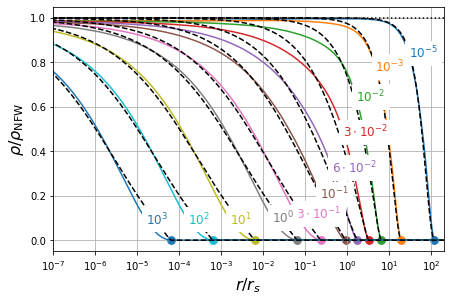

In [4]:
fig, ax = plt.subplots(1,1, figsize=(7,4.5))

nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)

ri = np.logspace(-8,3,401) * nfw.rs

rtids = []
for tidfac_rs in (1e-5,1e-3,1e-2,3e-2,6e-2,1e-1,3e-1,1e0,1e1,1e2,1e3):
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac_rs, niter=niter, h5cache=h5cache, verbose=0)
    
    #label=r"$10^{%d} \lambda_{s}$" % np.log10(tidfac_rs)
    if np.floor(np.log10(tidfac_rs)) == np.log10(tidfac_rs):
        label=r"$10^{%d}$" % np.log10(tidfac_rs)
    else:
        label=r"$%d\cdot10^{%d}$" % (np.round(tidfac_rs/10.**np.floor(np.log10(tidfac_rs))), np.floor(np.log10(tidfac_rs)))
    
    p = ax.semilogx(ri/nfw.rs, prof_ad.self_density(ri)/nfw.density(ri), label=label)
    
    def transfer_rsing(r, rpow1):
        res = np.zeros_like(r)
        rs, rt = nfw.rs, prof_ad._rtid
        x = (r[r < rt])/(rt - r[r < rt])
        #x = (rt)/(rt - r[r < rt])
        res[r < rt] = (1.+x**(3./2.*rpow1))**-(1./rpow1)#rpow2

        return res
    
    def plot_fit(ax, f, p0=1., **kwargs):
        par, cov = curve_fit(f, ri, prof_ad.self_density(ri)/nfw.density(ri), p0=p0)
        print("alpha = %.3f" % par[0])
        ax.plot(ri/nfw.rs, f(ri, *par), **kwargs)
    
    plot_fit(ax, transfer_rsing, p0=(1.5,), linestyle="dashed", color="black")
    
    ax.scatter(prof_ad._rtid/nfw.rs, 0, color=p[0].get_color(), s=60)
    
    rtids.append(prof_ad._rtid)

labelLines(ax.get_lines(),fontsize=12, xvals=np.array(rtids)/nfw.rs/4., backgroundcolor=(1.,1.,1.,1.), horizontalalignment="left", align=False)
    
ax.set_xticks(10.**np.linspace(-8,3,12))
ax.axhline(1., color="black", linestyle="dotted", label="NFW")
    

ax.grid("on")
ax.set_xlabel(r"$r / r_s$", fontsize=16)
ax.set_ylabel(r"$\rho / \rho_{\rm{NFW}}$", fontsize=16)

ax.set_xlim(1e-7, 2e2)

#plt.savefig("plots/radial_suppression_function.pdf", bbox_inches="tight")

# Velocity profiles and Tidal Track

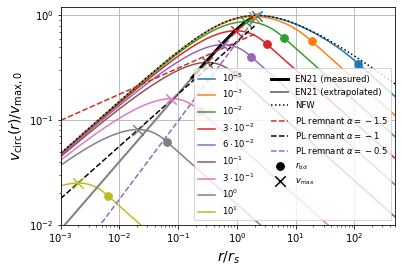

In [5]:
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)

fig, ax = plt.subplots(1,1, figsize=(6,4))

ri = np.logspace(-8,3,401) * nfw.rs

rvmax_nfw = at.profiles.find_tidal_boundary(nfw, mode="vmax")
vmax_nfw = np.sqrt(nfw.G*nfw.m_of_r(rvmax_nfw)/rvmax_nfw)

rtids = []
for tidfac_rs in (1e-5,1e-3,1e-2,3e-2,6e-2,1e-1,3e-1,1e0,1e1,1e2,1e3)[:-2]:
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac_rs, niter=niter, h5cache=h5cache, verbose=0)

    if np.floor(np.log10(tidfac_rs)) == np.log10(tidfac_rs):
        label=r"$10^{%d}$" % np.log10(tidfac_rs)
    else:
        label=r"$%d\cdot10^{%d}$" % (np.round(tidfac_rs/10.**np.floor(np.log10(tidfac_rs))), np.floor(np.log10(tidfac_rs)))
    
    def vcirc(r):
        return np.sqrt(prof_ad.G*prof_ad.self_m_of_r(r)/r) / vmax_nfw
    
    p = ax.loglog(ri/nfw.rs, vcirc(ri), label=label) #/nfw.density(ri)

    ax.scatter(prof_ad._rtid/nfw.rs, vcirc(prof_ad._rtid), color=p[0].get_color(), s=60)
    
    rvmax = at.profiles.find_tidal_boundary(prof_ad, mode="vmaxself")
    ax.scatter(rvmax/nfw.rs, vcirc(rvmax), color=p[0].get_color(), s=110, marker="x", zorder=5)
    
    rtids.append(prof_ad._rtid)

rmax0, vmax0 = 2.163, 1.
rmax = np.logspace(-6,0, 300) * rmax0
alpha, beta = 0.4, 0.65

vmax = vmax0 * 2**alpha * (rmax/rmax0)**beta * (1 + (rmax/rmax0)**2)**-alpha
plt.plot(rmax[vmax > 0.25], vmax[vmax > 0.25], color="black", linestyle="solid", lw=3, label = "EN21 (measured)")
plt.plot(rmax[vmax <= 0.25], vmax[vmax <= 0.25], color="grey", linestyle="solid", lw=2, label = "EN21 (extrapolated)")

ax.set_xticks(10.**np.linspace(-8,3,12))
ax.loglog(ri/nfw.rs, np.sqrt(nfw.G*nfw.m_of_r(ri)/ri)/vmax_nfw, color="black", linestyle="dotted", label="NFW")

ax.scatter([],[], color="black", s=60, label=r"$r_{\rm{tid}}$")
ax.scatter([],[], color="black", label=r"$v_{\rm{max}}$", s=110, marker="x")


ri = np.logspace(-3, 0.3) * nfw.rs

pprofm1 = at.profiles.PowerlawProfile(slope=-1, rhoc=nfw.rhoc, rscale=nfw.rs)
for slope, mfac,rvmfac,vmfac,lfac,rhocfac,color in (-1.5, 1.467e-02, 5.445e-02,3.430e-01, np.nan, 0.2,"C3"),(-1., 1.517e-05, 7.784e-03,3.257e-02, 5.196e-04, 1.,"black"), (-0.5, 3.159e-18, 5.655e-07,1.874e-06, 7.478e-17, 20., "C4"):
    pprof = at.profiles.PowerlawProfile(slope=slope, rhoc=nfw.rhoc*rhocfac, rscale=nfw.rs)

    vmi = vmfac * pprof.vcirc(nfw.rs) * (ri/nfw.rs / rvmfac)**((2. + slope)/2.)
    plt.loglog(ri / nfw.rs, vmi/vmax_nfw, linestyle="dashed", label=r"PL remnant $\alpha = %g$" % slope, color=color)

ax.legend(loc = "lower right", ncol=2, fontsize=8.5)
ax.grid("on")
ax.set_xlabel(r"$r / r_s$", fontsize=14)
ax.set_ylabel(r"$v_{\rm{circ}}(r) / v_{\rm{max,0}}$", fontsize=14)

ax.set_xlim(1e-3, 5e2)
ax.set_ylim(1e-2,1.2e0)

plt.savefig("plots/vcirc_profile.pdf", bbox_inches="tight")

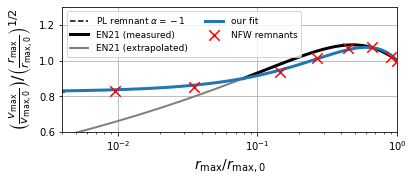

In [6]:
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)

fig, ax = plt.subplots(1,1, figsize=(6,2.3))

def xy(r, vcirc):
    return r/2.163, vcirc/(r/2.163)**0.5#r, vcirc / myfunc(r/2.163) #vcirc/(r/2.163)**0.5/0.8256

for i, tidfac_rs in enumerate((1e-5,1e-3,1e-2,3e-2,6e-2,1e-1,3e-1,1e0,1e1,1e2,1e3)[:-2]):
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac_rs, niter=niter, h5cache=h5cache, verbose=0)
    rvmax = at.profiles.find_tidal_boundary(prof_ad, mode="vmaxself")
    
    def vcirc(r):
        return np.sqrt(prof_ad.G*prof_ad.self_m_of_r(r)/r) / vmax_nfw
    if i == 0:
        label = "NFW remnants"
    else:
        label = None
    ax.scatter(*xy(rvmax/nfw.rs, vcirc(rvmax)), color="red", s=110, marker="x", zorder=5, label=label)

slope, mfac,rvmfac,vmfac,lfac,rhocfac =  (-1., 1.517e-05, 7.784e-03,3.257e-02, 5.196e-04, 1.)
pprof = at.profiles.PowerlawProfile(slope=slope, rhoc=nfw.rhoc*rhocfac, rscale=nfw.rs)

rmaxnfw = 2.163*nfw.rs

vmi0 = 3.257e-02 * pprof.vcirc(nfw.rs) * (2.163 / 7.784e-03)**0.5 / vmax_nfw 

plt.plot(*xy(ri*2.163,vmi0*ri**0.5), linestyle="dashed", label=r"PL remnant $\alpha = %g$" % slope, color="black")

rmax0, vmax0 = 2.163, 1.
rmax = np.logspace(-6,0, 300) * rmax0
alpha, beta = 0.4, 0.65

vmax = vmax0 * 2**alpha * (rmax/rmax0)**beta * (1 + (rmax/rmax0)**2)**-alpha
ax.plot(*xy(rmax[vmax > 0.25], vmax[vmax > 0.25]), color="black", linestyle="solid", lw=3, label = "EN21 (measured)")
ax.plot(*xy(rmax[vmax <= 0.25], vmax[vmax <= 0.25]), color="grey", linestyle="solid", lw=2, label = "EN21 (extrapolated)")

ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(0.6,1.3)
ax.set_xlim(4e-3,1.)

def myfunc(x,  gamma=1.5):
    beta=0.8256
    delta = (1./beta - 1.  - gamma)
    
    return beta * x**0.5 * (1 + gamma*x + delta*x**1.5)

ri = np.logspace(-3, 0.,200)

ax.plot(*xy(ri*2.163, myfunc(ri)), lw=3, label="our fit")

ax.set_ylabel(r"$\left(\frac{v_{\rm{max}}}{v_{\rm{max,0}}}\right) / \left(\frac{r_{\rm{max}}}{r_{\rm{max,0}}} \right)^{1/2}$", fontsize=16)
ax.set_xlabel(r"$r_{\rm{max}} / r_{\rm{max,0}}$", fontsize=14)
ax.grid("on")

plt.legend(loc="upper left", fontsize=9, ncol=2)
plt.savefig("plots/tidal_track_fit.pdf", bbox_inches="tight")

# Summary Statistics 

In [7]:
def initial_tidal_boundary(nfw, lrs):
    tid_rs = np.abs(nfw.accr(nfw.rs) / nfw.rs)
    alpha = tid_rs * lrs
    prof_tid = at.profiles.RadialTidalProfile(alpha=alpha)
    
    prof_comp = at.profiles.CompositeProfile(nfw, prof_tid)
    rtid, phitid = prof_comp.tidal_boundary(getphi=True)
    rlmax, emax, lmax = prof_comp.tidal_lmax_radius(getphi=True, getl=True)
    
    return rtid, phitid, rlmax, emax, lmax

In [8]:
h5cache = "../../caches/subhalo_grid.hdf5"
niter = 100
tidfacs = np.logspace(-4, 2, 61)

nfw = at.profiles.NFWProfile(conc=10., m200c=1e6)

rphitid_relmax = []
pv_rphitid_relmax = [] 
m_remain = []

rvmax_nfw = at.profiles.find_tidal_boundary(nfw, mode="vmax")
vmax_nfw = np.sqrt(nfw.G*nfw.m_of_r(rvmax_nfw)/rvmax_nfw)
ann_nfw = nfw.integral_density_squared()

rvmax = []
vmax_frac = []
ann_fac = []
mrvmax = []

for tidfac_rs in tidfacs:
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac_rs, niter=niter, h5cache=h5cache, verbose=0)
    prof_ad._initialize_tidal_radius()
    m_remain.append(prof_ad.self_m_of_r(np.max(prof_ad.ri)))
    rphitid_relmax.append((prof_ad._rtid, prof_ad._phitid-prof_ad.potential(1e-10), prof_ad._rlmax, prof_ad._elmax, prof_ad._lmax,))
    pv_rphitid_relmax.append(initial_tidal_boundary(nfw, tidfac_rs))
    #print(prof_ad.potential(1e-10), prof_ad._phitid)
    
    rvmax.append(at.profiles.find_tidal_boundary(prof_ad, mode="vmaxself"))
    vmax_frac.append(np.sqrt(prof_ad.G*prof_ad.self_m_of_r(rvmax[-1])/rvmax[-1]) / vmax_nfw)
    ann_fac.append(prof_ad.integral_density_squared()/ann_nfw)
    
    mrvmax.append(prof_ad.self_m_of_r(rvmax[-1]))
    
rphitid_relmax = np.array(rphitid_relmax)
pv_rphitid_relmax  = np.array(pv_rphitid_relmax)

0.6903198532165571
0.8875540969927163
2.5886994495620885
41.41919119299342


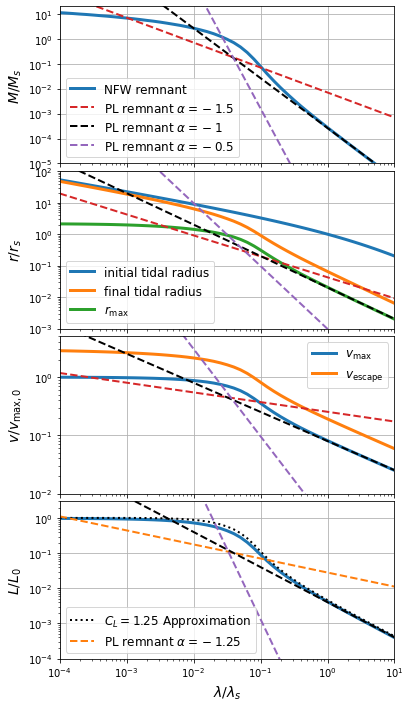

In [9]:
fig, axs = plt.subplots(4,1, figsize=(6,12), sharex=True)
fig.subplots_adjust(hspace=0.05)

axs[0].loglog(tidfacs, m_remain / nfw.m_of_r(nfw.rs), label="NFW remnant", lw=3)
axs[0].set_ylabel(r"$M / M_s$", fontsize=14)
axs[0].set_ylim(1e-5,2e1)

axs[1].loglog(tidfacs, pv_rphitid_relmax[:,0] / nfw.rs, label="initial tidal radius", lw=3)
axs[1].loglog(tidfacs, rphitid_relmax[:,0] / nfw.rs, label="final tidal radius", lw=3)
axs[1].loglog(tidfacs, np.array(rvmax) / nfw.rs, label=r"$r_{\rm{max}}$", lw=3)
axs[1].set_ylabel(r"$r / r_s$", fontsize=14)


axs[2].loglog(tidfacs, vmax_frac, label=r"$v_{\rm{max}}$", lw=3)
axs[2].loglog(tidfacs, np.sqrt(2.*np.abs(rphitid_relmax[:,1]))/ vmax_nfw, label=r"$v_{\rm{escape}}$", lw=3)
axs[2].set_ylim(1e-2, 5)
axs[2].set_ylabel(r"$v / v_{\rm{max,0}}$", fontsize=14)

axs[3].loglog(tidfacs, ann_fac, lw=3) #  label="NFW remnant Lum.", 
axs[3].set_ylabel(r"$L / L_0$", fontsize=14)

Cnfw = 4.*np.pi*2.16258/(3.*1.64**4) # = 1.252

nfwapprox = Cnfw*(np.array(vmax_frac)*vmax_nfw)**4/np.array(rvmax)/nfw.G**2
axs[3].loglog(tidfacs, nfwapprox/ann_nfw, label=r"$C_L = 1.25$ Approximation", linestyle="dotted", color="black", lw=2)

for slope, mfac,rvmfac,vmfac,lfac,rhocfac,color in (-1.5, 1.467e-02, 5.445e-02,3.430e-01, np.nan, 0.2,"C3"),(-1.25, 1.194e-03, 2.918e-02, 1.433e-01, 5.491e-02, 0.3,"C1"),(-1., 1.517e-05, 7.784e-03,3.257e-02, 5.196e-04, 1.,"black"), (-0.5, 3.159e-18, 5.655e-07,1.874e-06, 7.478e-17, 20., "C4"):
    pprof = at.profiles.PowerlawProfile(slope=slope, rhoc=nfw.rhoc*rhocfac, rscale=nfw.rs)
    lsfac = np.abs(pprof.accr(nfw.rs) / nfw.accr(nfw.rs))
    print(lsfac)
    
    if slope != -1.25:
        mb = mfac * (tidfacs/lsfac) ** ((3.+slope)/slope) * pprof.m_of_r(nfw.rs)
        axs[0].loglog(tidfacs, mb/nfw.m_of_r(nfw.rs), linestyle="dashed", label=r"PL remnant $\alpha = %g$" % slope, color=color, lw=2)
        rvm = rvmfac * (tidfacs/lsfac) ** (1./slope) * nfw.rs
        axs[1].loglog(tidfacs, rvm / nfw.rs, linestyle="dashed", color=color, lw=2)
        
        vm = vmfac * (tidfacs/lsfac) ** ((2.+slope)/(2.*slope)) * pprof.vcirc(nfw.rs)
        axs[2].loglog(tidfacs, vm / vmax_nfw, linestyle="dashed", color=color, lw=2)
    if slope != -1.5:
        lum = lfac * (tidfacs/lsfac) ** ((3.+2.*slope)/slope) * pprof.integral_density_squared(rmin=1e-12*nfw.rs, rmax=nfw.rs)
        if slope == -1.25:
            label=r"PL remnant $\alpha = %g$" % slope
        else:
            label=None
        axs[3].loglog(tidfacs, lum / ann_nfw, linestyle="dashed", label=label, color=color, lw=2)


axs[-1].set_xlabel(r"$\lambda / \lambda_s$", fontsize=14)

axs[1].set_ylim(1e-3,1e2)
axs[3].set_ylim(1e-4,3e0)

axs[0].set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])

for ax in axs:
    ax.grid("on")
    ax.set_xlim(1e-4,1e1)
    ax.legend(fontsize=12)

plt.savefig("plots/tide_vs_summary_statistics.pdf", bbox_inches="tight")

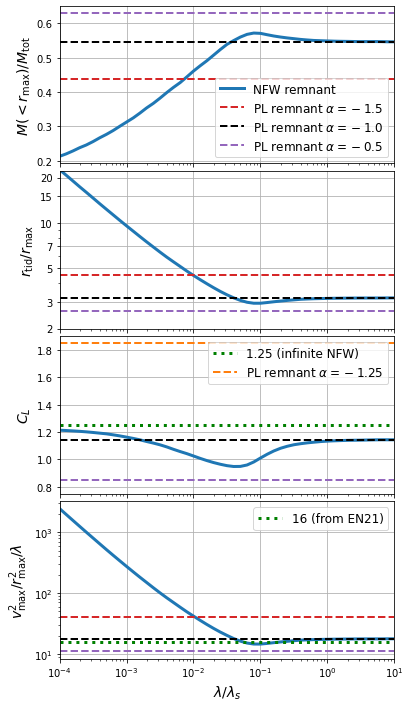

In [10]:
fig, axs = plt.subplots(4,1, figsize=(6,12), sharex=True)
fig.subplots_adjust(hspace=0.05)

axs[0].semilogx(tidfacs, np.array(mrvmax) / np.array(m_remain), lw=3, label="NFW remnant")
axs[0].set_ylabel(r"$M(<r_{\rm{max}}) / M_{\rm{tot}}$", fontsize=14)


axs[1].loglog(tidfacs, rphitid_relmax[:,0]/np.array(rvmax), lw=3) # , label=r"our model"
axs[1].set_ylabel(r"$r_{\rm{tid}} / r_{\rm{max}}$", fontsize=14)

Lfac = (np.array(vmax_frac)*vmax_nfw)**4/np.array(rvmax)/nfw.G**2
axs[2].semilogx(tidfacs, ann_fac/(Lfac/ann_nfw), lw=3) # , label=r"our model"
axs[2].set_ylabel(r"$C_L$", fontsize=14)
axs[2].axhline(1.252, linestyle="dotted", color="green", label=r"1.25 (infinite NFW)", lw=3)
axs[2].set_ylim(0.75,1.9)

Tfac = (np.array(vmax_frac)*vmax_nfw/np.array(rvmax))**2 /(nfw.G * np.array(tidfacs) * nfw.m_of_r(nfw.rs) / nfw.rs**3)
axs[3].loglog(tidfacs, Tfac, lw=3)
axs[3].set_ylabel(r"$v_{\rm{max}}^2 / r_{\rm{max}}^2 / \lambda$", fontsize=14)
axs[3].axhline(16., label="16 (from EN21)", linestyle="dotted", color="green", lw=3)

axs[-1].set_xlabel(r"$\lambda / \lambda_s$", fontsize=14)

        
mt = [1,2,3,5,7,10,15,20,30]
axs[1].set_yticks(mt)
axs[1].set_yticklabels(mt)

for slope, rtfac,mfac,rvmfac,vmfac,lfac,mmaxfac,cl,rhocfac,color in [(-1.5, 2.448e-01, 1.467e-02, 5.445e-02,3.430e-01, np.nan,4.367e-01, np.nan, 0.2,"C3"),
                                                                  (-1.25, 1.061e-01, 1.194e-03, 2.918e-02, 1.433e-01, 5.491e-02, 5.018e-01, 1.850e+00, 0.3,"C1"),
                                                                  (-1., 2.475e-02, 1.517e-05, 7.784e-03,3.257e-02, 5.196e-04, 5.445e-01, 1.144e+00, 1.,"black"), 
                                                                  (-0.5, 1.467e-06, 3.159e-18, 5.655e-07,1.874e-06, 7.478e-17,  6.287e-01, 8.524e-01, 20., "C4")]:
    pprof = at.profiles.PowerlawProfile(slope=slope, rhoc=nfw.rhoc*rhocfac, rscale=nfw.rs)

    
    if slope != -1.25:
        axs[0].axhline(mmaxfac, linestyle="dashed", label=r"PL remnant $\alpha = %.1f$" % slope, color=color, lw=2) # label=r"TPL $\alpha = %.1f$ (%.1f%%)" % (slope, mmaxfac*100.)
        axs[1].axhline(rtfac/rvmfac, linestyle="dashed", color=color, lw=2) # , label=r"TPL $\alpha = %.1f$ (%.1f)" % (slope, rtfac/rvmfac)
        Tfac = (vmfac/rvmfac)**2
        axs[3].axhline(Tfac, linestyle="dashed", color=color, lw=2) # , label=r"TPL $\alpha = %.1f$ (%.1f)" % (slope, Tfac)

    if slope != -1.5:
        if slope == -1.25:
            label=r"PL remnant $\alpha = %.2f$" % (slope) # r"TPL $\alpha = %.2f$ (%.2f)" % (slope, cl)
        else:
            label = None
        axs[2].axhline(cl, linestyle="dashed", label=label, color=color, lw=2)

axs[1].set_ylim(2,22.)

for i,ax in enumerate(axs):
    ax.grid("on")
    ax.set_xlim(1e-4,1e1)
    
    if i != 1:
        ax.legend(fontsize=12, loc="best")
    
#plt.savefig("plots/tide_vs_vmax_statistics.pdf", bbox_inches="tight")

# GW21 Annihilation check

In [11]:
for tidfac_rs in 5e-2,1e-1,2e-1:
    tidfac2 = tidfac_rs/3.4

    prof_ad1 = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac_rs, niter=niter, h5cache=h5cache, verbose=0)
    prof_ad2 = at.profiles.AdiabaticProfile(nfw, tidfac_rs=tidfac2, niter=niter, h5cache=h5cache, verbose=0)
    
    print("lam %.3f -> %.3f, J*= %.3f" % (tidfac_rs, tidfac2, prof_ad2.integral_density_squared()/prof_ad1.integral_density_squared()))

lam 0.050 -> 0.015, J*= 2.306
lam 0.100 -> 0.029, J*= 5.083
lam 0.200 -> 0.059, J*= 7.922
